In [ ]:
from vocab import MixVocab, Vocab
mixvocab = MixVocab.load('dataset/mix_vocab.json')
vocab = Vocab.load('dataset/vocab.json')
vocab.load_embeddings('dataset/vocab_embeddings.pkl')
mixvocab.load_embeddings('dataset/mix_vocab_embeddings.pkl')

In [ ]:
from sklearn.utils import shuffle
from dataset import Dataset
import numpy as np
def create_dataset(is_train):
        if is_train:
            dataset = Dataset.create_from_file('dataset/train.jsonl')
        else:
            dataset = Dataset.create_from_file('dataset/test.jsonl')

        code_data, comment_data, Y = [], [], []

        # Pretrained embeddings
        EM = np.array(mixvocab.token.embeddings)

        for example in dataset.train_batch_iter(1, shuffle=False):
            # take mean of embeddings
            new_code_tokens = np.mean(EM[mixvocab.token.words2indices(example.new_code_tokens)[0]], axis=0)
            src_tokens = np.mean(EM[mixvocab.token.words2indices(example.src_tokens)[0]], axis=0)
            tgt_tokens = np.mean(EM[mixvocab.token.words2indices(example.tgt_tokens)[0]], axis=0)

            # new code and source(old) tokens --> inconsistency --> positive example
            code_data.append(new_code_tokens)
            comment_data.append(src_tokens)
            Y.append(1)
            # new code and target(new) tokens ---> consistency --> negative example
            code_data.append(new_code_tokens)
            comment_data.append(tgt_tokens)
            Y.append(0)
        # concatenate comments and code mean embeddings
        return np.concatenate((code_data, comment_data), axis=1), Y

In [10]:
testX, testY = create_dataset(is_train=False)
testX, testY = shuffle(testX, testY)

INFO:root:loading 9673 samples


In [11]:
X, Y = create_dataset(is_train=True)
X, Y = shuffle(X, Y)

INFO:root:loading 85657 samples


In [ ]:
!pip install matplotlib

In [15]:
import matplotlib.pyplot as plt
from sklearn.base import clone
# Create plots (train_size, model_accuracy on train) and (train_size, model_accuracy on test) for all models
def test_models(X, Y, testX, testY, train_sizes, test_size, models):
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')
    num = 0
    for model, model_name in models:
        num += 1
        train_vals = []
        test_vals = []
        for train_size in train_sizes:
            model = clone(model) # refresh model
            model.fit(X[:train_size], Y[:train_size])
            train_vals.append(model.score(X[:train_size], Y[:train_size]))
            test_vals.append(model.score(testX[:test_size], testY[:test_size]))
        plt.subplot(121)
        plt.plot(train_sizes, train_vals, marker='', color=palette(num), linewidth=1, alpha=0.9, label=model_name)
        plt.subplot(122)
        plt.plot(train_sizes, test_vals, marker='', color=palette(num), linewidth=1, alpha=0.9, label=model_name)
    plt.legend(loc=2, ncol=2)
    plt.title("train_size to accuracy", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Size")
    plt.ylabel("Score")
    plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-15-48aaaaeb9cbc>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-15-48aaaaeb9cbc>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance. 

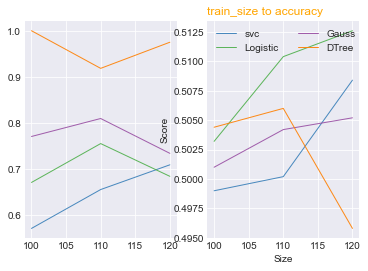

In [19]:
# Really long to run with this train sizes (on my computer)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

train_sizes = [100, 500, 1000, 10000, 50000] # up to 170 000
test_size = 5000 # up to 19 000
models = [(SVC(), 'svc'),
          (LogisticRegression(random_state=0,  max_iter=1000, verbose=1), 'Logistic'),
          (GaussianNB(), 'Gauss'),
          (DecisionTreeClassifier(max_depth=5), 'DTree')]
test_models(X, Y, testX, testY, train_sizes, test_size, models)